In [9]:
import seaborn as sns
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append("../")

In [3]:
from src.domain_shift_diagnosis.models import model_registry
from src.domain_shift_diagnosis.pipelines.train_model.utils import compute_mask_from_weights
from src.domain_shift_diagnosis.pipelines.test_model.utils import univariate_wasserstein_dist, shift_detection_score

# Shift Diagnosis on Tenesse Eastman process dataset
In this notebook, we're testing our shift diagnosis framework on a the Tenesse Eastman Process dataset. A dataset that simulates actual chemical processes and which is widely used as a benchmark in test fault diagnosis and process control.

## Loading data
### Source Data
The source data is made of "fault-free" samples of the normal behavior of the process.

In [6]:
source_data = pd.read_parquet("./tenessee_eastman_process_source.parquet")
source_data

xmeas_1  xmeas_2  xmeas_3  xmeas_4  xmeas_5  \
faultNumber simulationRun sample                                                
0           1             1       0.25171   3672.4   4466.3   9.5122   27.057   
                          2       0.25234   3642.2   4568.7   9.4145   26.999   
                          3       0.24840   3643.1   4507.5   9.2901   26.927   
                          4       0.25153   3628.3   4519.3   9.3347   26.999   
                          5       0.21763   3655.8   4571.0   9.3087   26.901   
...                                   ...      ...      ...      ...      ...   
            50            956     0.26992   3625.0   4484.0   9.4913   26.471   
                          957     0.19743   3595.3   4495.0   9.2979   27.055   
                          958     0.19811   3620.6   4534.3   9.5247   26.684   
                          959     0.27228   3657.9   4491.6   9.5424   26.839   
                          960     0.27018   3678.0   4482.6   9.4452   27.386   

                                  xmeas_6  xmeas_7  xmeas_8  xmeas_9  \
faultNumber simulationRun sample                                       
0           1             1        42.473   2705.6   74.750   120.41   
                          2        42.586   2705.2   75.126   120.38   
                          3        42.278   2703.5   74.540   120.38   
                          4        42.330   2703.9   74.861   120.38   
                          5        42.402   2707.7   74.380   120.40   
...                                   ...      ...      ...      ...   
            50            956      42.239   2706.0   74.816   120.43   
                          957      42.362   2704.1   75.147   120.34   
                          958      41.812   2704.1   73.747   120.40   
                          959      42.580   2709.0   74.474   120.40   
                          960      42.532   2713.7   75.323   120.42   

                                  xmeas_10  ...   xmv_2   xmv_3   xmv_4  \
faultNumber simulationRun sample            ...                           
0           1             1        0.33642  ...  54.494  24.527  59.710   
                          2        0.33801  ...  53.269  24.465  60.466   
                          3        0.33702  ...  54.000  24.860  60.642   
                          4        0.33648  ...  53.860  24.553  61.908   
                          5        0.32114  ...  53.307  21.775  61.891   
...                                    ...  ...     ...     ...     ...   
            50            956      0.33453  ...  54.077  26.453  62.705   
                          957      0.35108  ...  54.027  19.692  63.927   
                          958      0.34552  ...  53.557  19.626  62.817   
                          959      0.33537  ...  54.194  26.456  62.291   
                          960      0.33728  ...  54.303  26.662  60.305   

                                   xmv_5   xmv_6   xmv_7   xmv_8   xmv_9  \
faultNumber simulationRun sample                                           
0           1             1       22.357  40.149  40.074  47.955  47.300   
                          2       22.413  39.956  36.651  45.038  47.502   
                          3       22.199  40.074  41.868  44.553  47.479   
                          4       21.981  40.141  40.066  48.048  47.440   
                          5       22.412  37.696  38.295  44.678  47.530   
...                                  ...     ...     ...     ...     ...   
            50            956     22.405  39.825  42.313  43.199  51.717   
                          957     23.044  40.888  41.990  47.718  51.585   
                          958     22.827  41.566  40.403  51.261  51.646   
                          959     22.621  39.690  43.421  47.512  51.425   
                          960     23.205  39.457  39.034  44.251  51.708   

                                  xmv_10  xmv_11  
faultNumber simulationRun s

### Target Data
The target data is made of "faulty" samples, recorded in abnormal conditions. The goal is to compare this dataset to the source data in order to isolate sources of shift.

In [8]:
target_data = pd.read_parquet("./tenessee_eastman_process_target.parquet")
target_data

xmeas_1  xmeas_2  xmeas_3  xmeas_4  xmeas_5  \
faultNumber simulationRun sample                                                
1           1             1       0.25171   3672.4   4466.3   9.5122   27.057   
                          2       0.25234   3642.2   4568.7   9.4145   26.999   
                          3       0.24840   3643.1   4507.5   9.2901   26.927   
                          4       0.25153   3628.3   4519.3   9.3347   26.999   
                          5       0.21763   3655.8   4571.0   9.3087   26.901   
...                                   ...      ...      ...      ...      ...   
20          1             956     0.27389   3638.5   4512.7   9.3480   26.764   
                          957     0.25405   3656.7   4490.2   9.3897   27.067   
                          958     0.25664   3645.5   4506.3   9.4222   26.647   
                          959     0.21993   3686.1   4507.0   9.3934   26.625   
                          960     0.22310   3664.2   4482.3   9.4352   27.163   

                                  xmeas_6  xmeas_7  xmeas_8  xmeas_9  \
faultNumber simulationRun sample                                       
1           1             1        42.473   2705.6   74.750   120.41   
                          2        42.586   2705.2   75.126   120.38   
                          3        42.278   2703.5   74.540   120.38   
                          4        42.330   2703.9   74.861   120.38   
                          5        42.402   2707.7   74.380   120.40   
...                                   ...      ...      ...      ...   
20          1             956      42.231   2713.2   74.348   120.43   
                          957      42.065   2715.9   74.945   120.40   
                          958      42.139   2715.5   74.313   120.41   
                          959      42.214   2710.9   74.022   120.40   
                          960      42.283   2709.7   74.906   120.40   

                                  xmeas_10  ...   xmv_2   xmv_3   xmv_4  \
faultNumber simulationRun sample            ...                           
1           1             1        0.33642  ...  54.494  24.527  59.710   
                          2        0.33801  ...  53.269  24.465  60.466   
                          3        0.33702  ...  54.000  24.860  60.642   
                          4        0.33648  ...  53.860  24.553  61.908   
                          5        0.32114  ...  53.307  21.775  61.891   
...                                    ...  ...     ...     ...     ...   
20          1             956      0.31466  ...  54.051  26.807  63.206   
                          957      0.31525  ...  54.334  25.185  61.865   
                          958      0.31779  ...  54.141  24.931  63.582   
                          959      0.32622  ...  53.535  21.874  61.885   
                          960      0.32928  ...  53.831  21.562  63.215   

                                   xmv_5   xmv_6   xmv_7   xmv_8   xmv_9  \
faultNumber simulationRun sample                                           
1           1             1       22.357  40.149  40.074  47.955  47.300   
                          2       22.413  39.956  36.651  45.038  47.502   
                          3       22.199  40.074  41.868  44.553  47.479   
                          4       21.981  40.141  40.066  48.048  47.440   
                          5       22.412  37.696  38.295  44.678  47.530   
...                                  ...     ...     ...     ...     ...   
20          1             956     21.214  36.950  39.891  48.834  49.969   
                          957     21.657  37.441  41.566  50.203  50.270   
                          958     20.960  37.131  36.523  42.912  50.497   
                          959     20.723  38.850  42.909  47.052  50.774   
                          960     21.093  38.475  43.448  42.506  50.860   

                                  xmv_10  xmv_11  
faultNumber simulationRun s

## Models Parameters
### Parameters of the encoder

In [7]:
parameters = {}

encoder_params = {
    "mu_regressor_params": {
        "mlp_params": {},
        "linear_params": {
            "l1_kernel": 0.0001
        }
    },
    "logvar_regressor_params": {
        "mlp_params": {
            "hidden_units": [256, 128],
            "dropout_rate": 0.05
        },
        "linear_params": {
            "l1_kernel": 0.0001
        }
    }
}

### Linear VAE

In [8]:
parameters["LinearVAE"] = {
    "encoder_params": encoder_params,
    "decoder_params": {
        "mu_regressor_params": {
            "mlp_params": {},
            "linear_params": {}
        },
        "logvar_regressor_params": {
            "mlp_params": {},
            "linear_params": {}
        }
    },
    "beta": 0.25,
    "variance_type": "feature"
}

### Lasso VAE

In [9]:
parameters["LassoVAE"] = {
    "encoder_params": encoder_params,
    "decoder_params": {
        "mu_regressor_params": {
            "mlp_params": {},
            "linear_params": {"l1_kernel": 0.05}
        },
        "logvar_regressor_params": {
            "mlp_params": {},
            "linear_params": {}
        }
    },
    "beta": 0.25,
    "variance_type": "feature",
}

### Sparse VAE

In [99]:
parameters["SparseVAE"] = {
    "encoder_params": encoder_params,
    "decoder_params": {
        "mu_regressor_params": {
            "mlp_params": {},
            "linear_params": {"l2_kernel": 0.001}
        },
        "logvar_regressor_params": {
            "mlp_params": {},
            "linear_params": {}
        },
        "sparse_mapping_params": {
            "lambda0": 10,
            "lambda1": 0.01,
            "lambda0_step": 0.01,
            "a": 1,
            "b": 30
        },
    },
    "beta": 0.25,
    "variance_type": "feature"
}

## Training

In [100]:
SEED = 0

In [101]:
# Scaling
scaler = StandardScaler().fit(source_data.values)
source_data.iloc[:, :] = scaler.transform(source_data.values)

input_dim = source_data.shape[1]
latent_dim = input_dim

# Train / Test Split
X_train, X_test = train_test_split(source_data.values, test_size=0.3, random_state=SEED)

In [ ]:
models = {}

for model_name in ["SparseVAE", "LassoVAE", "LinearVAE"]:

    model = model_registry[model_name](input_dim, latent_dim, random_state=SEED, **parameters[model_name])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        metrics={"mu": ["mse", "mae"]},
    )
    model.fit(X_train, X_test, epochs=100, batch_size=256, patience=5, monitor="val_mu_mse")
    models[model_name] = model

## Shift Diagnosis

In [ ]:
target_data.iloc[:, :] = scaler.transform(target_data.values)

#### Computing the shift profile of each type of fault
The output figures are saved under "figures/TEP_experiments/".

In [ ]:
def shift_detection_score(X_shift: pd.DataFrame) -> pd.DataFrame:

    # Sort all rows by descending order
    scores = X_shift.apply(
        lambda row: pd.Series(row.dropna().sort_values(ascending=False).values),
        axis=1,
    )

    # Normalize
    scores = scores / scores.sum(1).values.reshape(-1, 1)

    # Computes the crossentropy between each row and a theoritical
    # unitary shift profile: [1, 0, 0, ..., 0]
    scores = -np.log(scores.iloc[:, 0])
    return pd.Series(scores, index=X_shift.index)

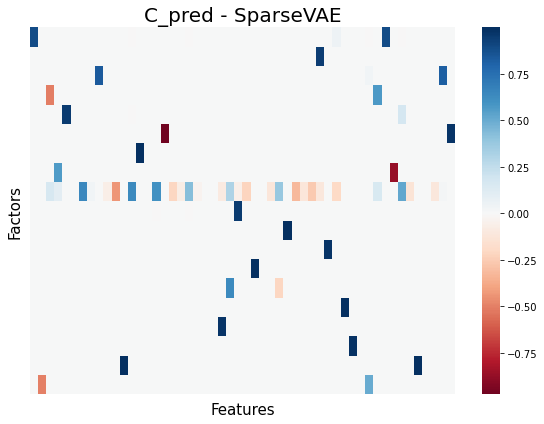

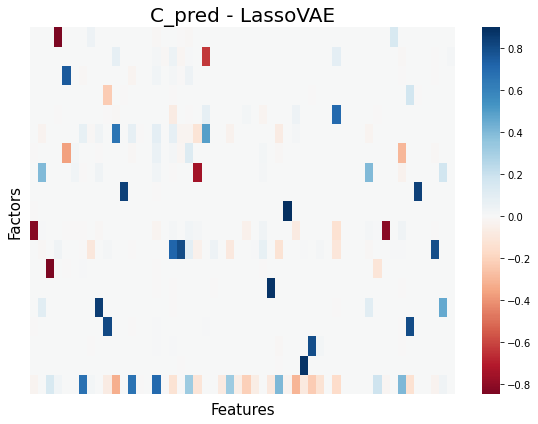

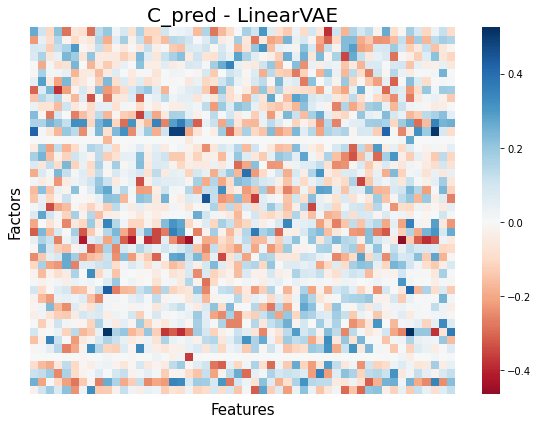

In [ ]:
shift_detection_scores = []

for model_name, model in models.items():
    
    _, mask_features, latent_dim_pred = compute_mask_from_weights(models[model_name].get_factors_mapping())
    is_factor_active = mask_features["is_factor_active"]

    Z_columns = [f"Z{i}" for i in range(is_factor_active.sum())]

    Z_source = models[model_name].transform(source_data.values)

    Z_source = pd.DataFrame(
        Z_source[:, is_factor_active],
        index=source_data.index,
        columns=Z_columns
    )

    Z_target = models[model_name].transform(target_data.values)

    Z_target = pd.DataFrame(
        Z_target[:, is_factor_active],
        index=target_data.index,
        columns=Z_columns
    )

    Z_shift = (
        Z_target.groupby(
            [
                "faultNumber",
            ]
        )
        .apply(
            lambda df: pd.Series(
                univariate_wasserstein_dist(
                    Z_source.values, df.values
                ),
                index=Z_columns,
            )
        )
    )


    C_pred = plt.figure(figsize=(8, 6))
    sns.heatmap(
        model.get_factors_mapping()[is_factor_active], cmap="RdBu", center=0
    )
    plt.title(f"C_pred - {model_name}", fontsize=20)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Features", fontsize=15)
    plt.ylabel("Factors", fontsize=15)
    plt.tight_layout()
    C_pred.savefig(f"./figures/TEP_experiments/C_pred_{model_name}.pdf")

    SDS = shift_detection_score(Z_shift)
    SDS.name = "SDS"
    SDS = SDS.reset_index()
    SDS["Model"] = model_name

    shift_detection_scores.append(SDS)

### Shift Dispersion Scores

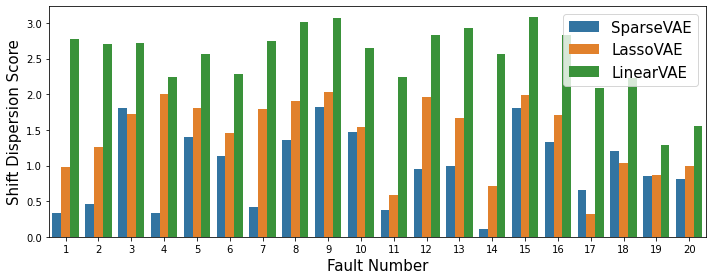

In [111]:
fig = plt.figure(figsize=(10, 4))
sns.barplot(
    data=pd.concat(shift_detection_scores, axis=0),
    x="faultNumber", y="SDS", hue="Model"
)
plt.ylabel("Shift Dispersion Score", fontsize=15)
plt.xlabel("Fault Number", fontsize=15)
plt.tight_layout()
plt.legend(fontsize=15)
fig.savefig(f"./figures/TEP_experiments/SDS.pdf")